<a href="https://colab.research.google.com/github/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification to detect sensitive data exposure

## Importing libraries and downloading the dataset

In [1]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import os

In [2]:
git_folder = "C:\\Users\\LAKSHMI SRI LASYA\\Documents\\research\\Detection-of-Sensitive-Data-Exposure-in-Images"
training_folder = git_folder + "/dataset/training"
validation_folder = git_folder + "/dataset/validation"

In [3]:
train_sensitive_dir = os.path.join(training_folder + "/sensitive")
train_nonsensitive_dir = os.path.join(training_folder + "/nonsensitive")
validation_sensitive_dir = os.path.join(validation_folder + "/sensitive")
validation_nonsensitive_dir = os.path.join(validation_folder + "/nonsensitive")

In [4]:
print(train_nonsensitive_dir)

C:\Users\LAKSHMI SRI LASYA\Documents\research\Detection-of-Sensitive-Data-Exposure-in-Images/dataset/training/nonsensitive


In [5]:
# Image Dataset size
print('Total training sensitive images:', len(os.listdir(train_sensitive_dir)))
print('Total training nonsensitive images:', len(os.listdir(train_nonsensitive_dir)))
print('Total validation sensitive images:', len(os.listdir(validation_sensitive_dir)))
print('Total validation nonsensitive images:', len(os.listdir(validation_nonsensitive_dir)))

Total training sensitive images: 300
Total training nonsensitive images: 300
Total validation sensitive images: 50
Total validation nonsensitive images: 50


## Sample Data

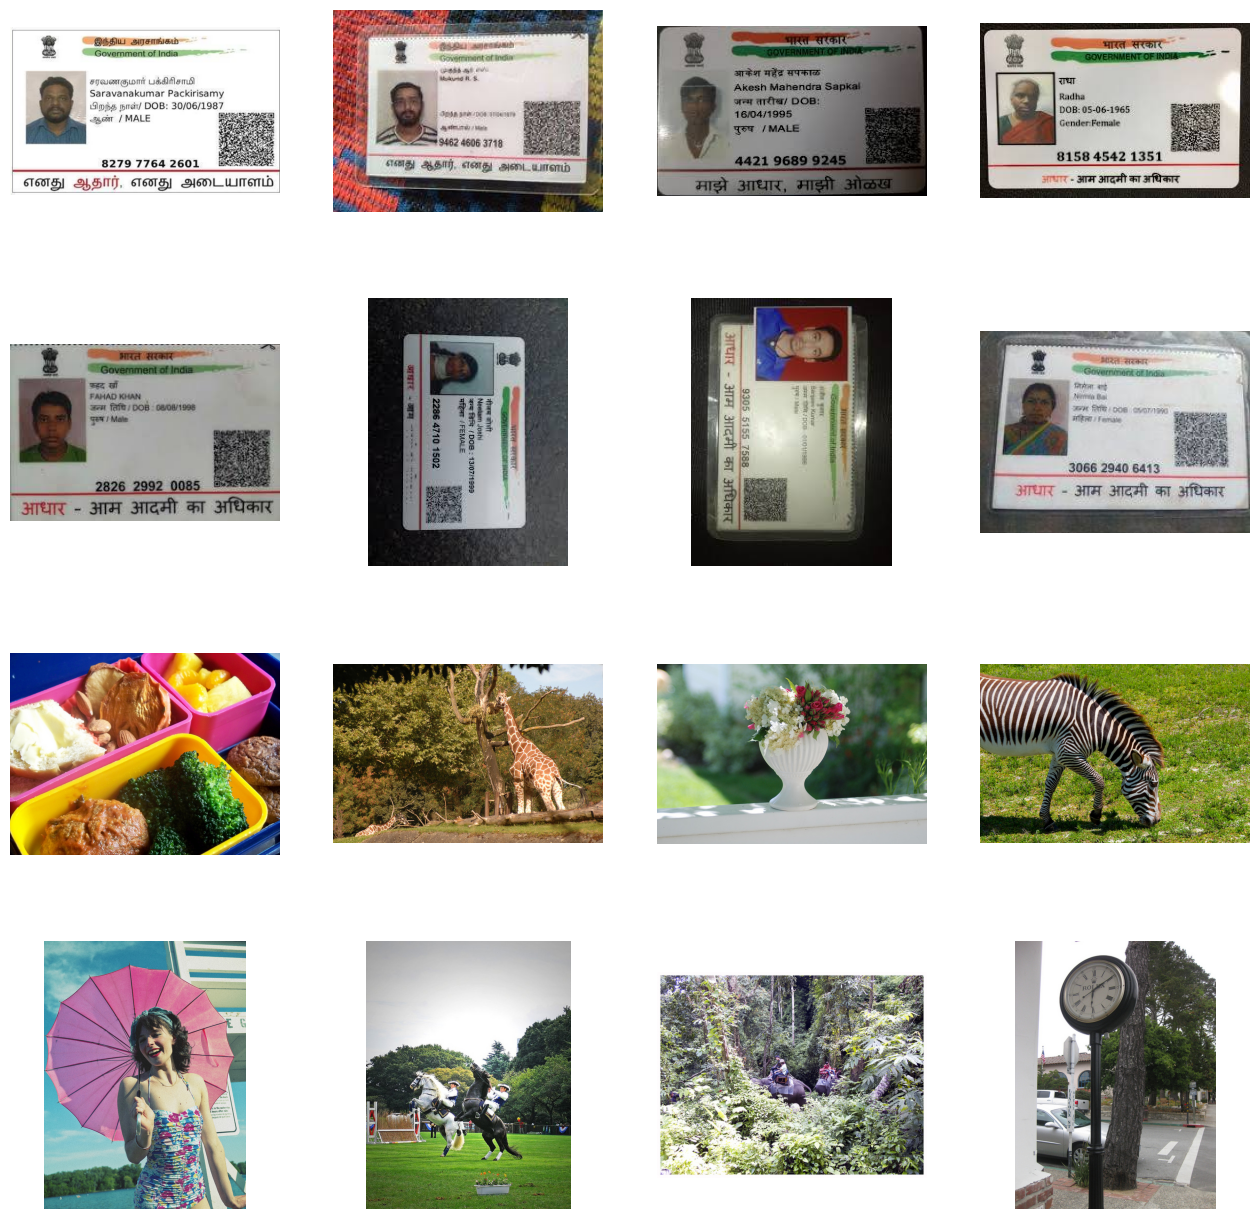

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_sensitive_dir = os.path.join(training_folder+"/sensitive")
train_nonsensitive_dir = os.path.join(training_folder+"/nonsensitive")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname) 
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname) 
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Model

In [7]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.98

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 98% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.models.Sequential([
  # 2D Convolution Layer - Filter, Kernel_size, activation fn
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  # Max pooling operation for 2D data - Pool size
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flattens the input. Does not affect the batch size.
  tf.keras.layers.Flatten(),
  # Regular densely-connected Neural Network layer with ReLU activation function.
  tf.keras.layers.Dense(512, activation='relu'),
  # Regular densely-connected Neural Network layer with sigmoid activation function.
  tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)     

## Preprocessing, Data Augmentation & Training

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling - 1/255 is to transform every pixel value from range [0,255] -> [0,1]
# Performing image augmentation for training data
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# flow_from_directory - Takes the path to a directory & generates batches of data.
train_generator = train_datagen.flow_from_directory(
        training_folder,
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary',
        shuffle=True
       )

validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary',
        shuffle=True
        )

num_epochs = 500
# model.fit - Train the model for a fixed number of epochs
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=num_epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[callbacks])

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/500


10/10 [==============================] - 13s 1s/step - loss: 0.8209 - accuracy: 0.5133 - val_loss: 0.6370 - val_accuracy: 0.6000
Epoch 2/500
10/10 [==============================] - 9s 938ms/step - loss: 0.6855 - accuracy: 0.5067 - val_loss: 0.6495 - val_accuracy: 0.9000
Epoch 3/500
10/10 [==============================] - 9s 845ms/step - loss: 0.6262 - accuracy: 0.6717 - val_loss: 0.4546 - val_accuracy: 0.8250
Epoch 4/500
10/10 [==============================] - 8s 827ms/step - loss: 0.5436 - accuracy: 0.7233 - val_loss: 0.3865 - val_accuracy: 0.7750
Epoch 5/500
10/10 [==============================] - 9s 846ms/step - loss: 0.4705 - accuracy: 0.7667 - val_loss: 0.6341 - val_accuracy: 0.6750
Epoch 6/500
10/10 [==============================] - 10s 1s/step - loss: 0.6075 - accuracy: 0.7050 - val_loss: 0.4948 - val_accuracy: 0.8250
Epoch 7/500
10/10 [==============================] - 10s 998ms

## Plotting Accuracy and Loss Functions

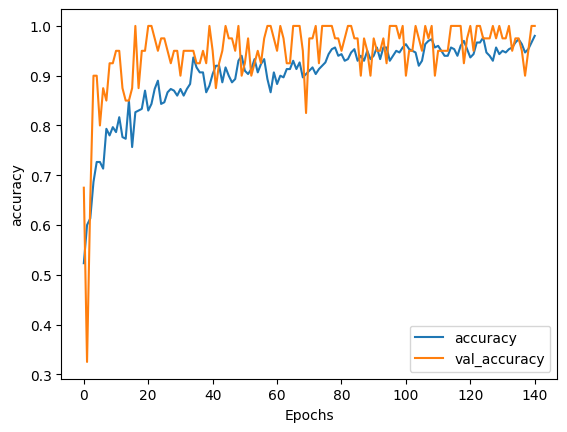

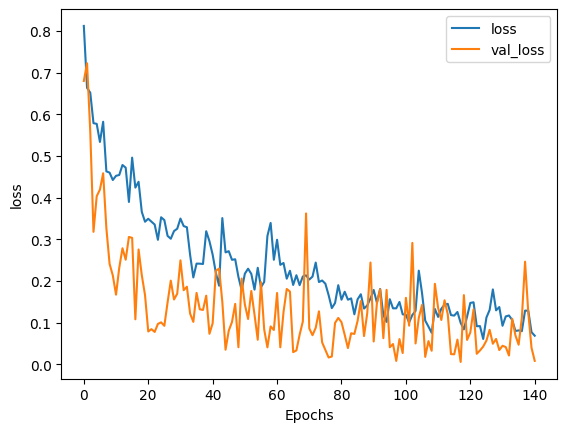

In [10]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix

20/20 [==============================] - 1s 28ms/step
Confusion Matrix
Accuracy for 25 Test Data =  60.0
Accuracy for 50 Test Data =  53.06122448979592
Accuracy for 75 Test Data =  50.66666666666667
Accuracy for 100 Test Data =  53.535353535353536


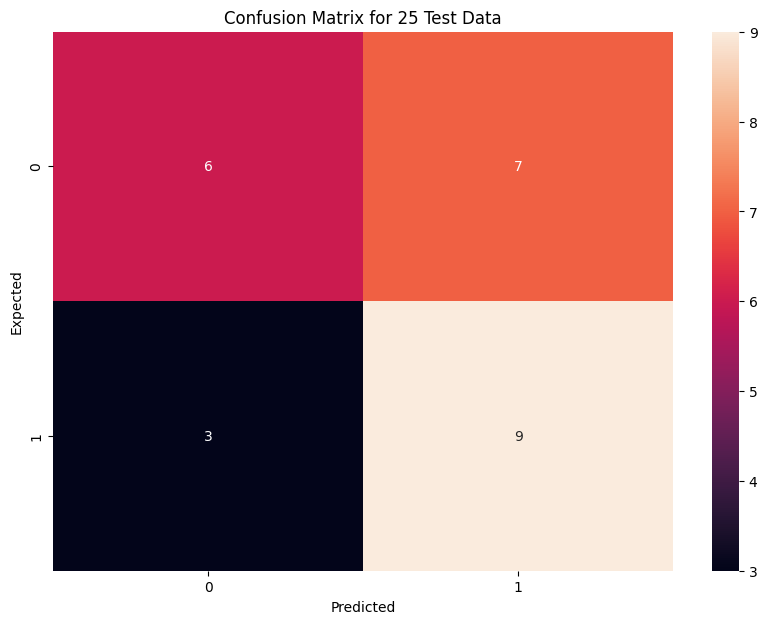

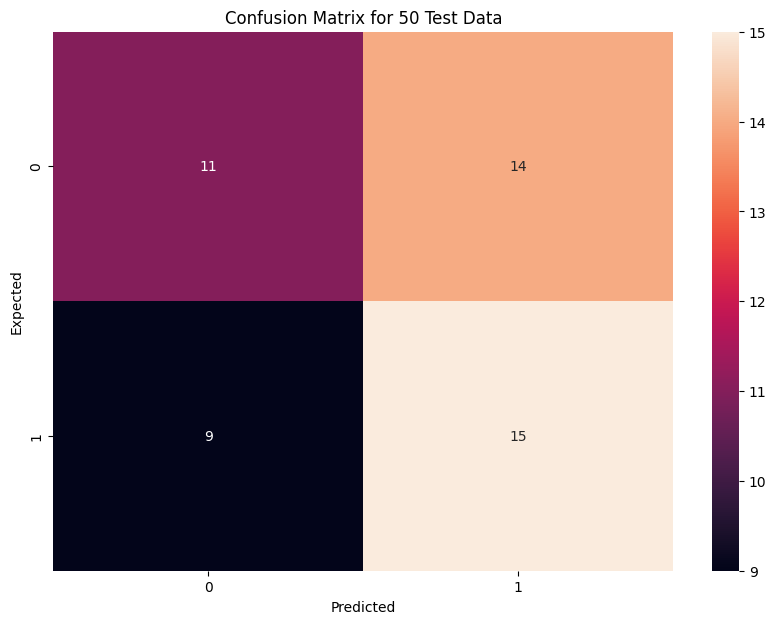

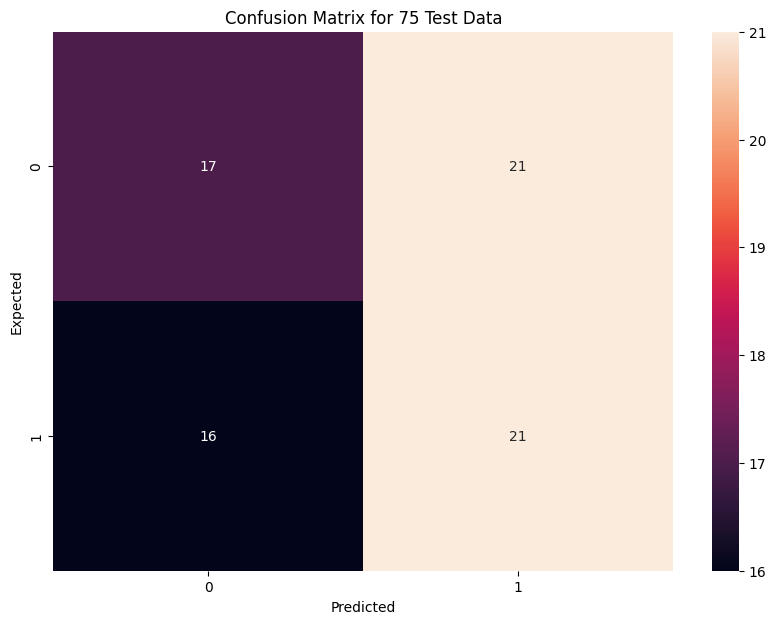

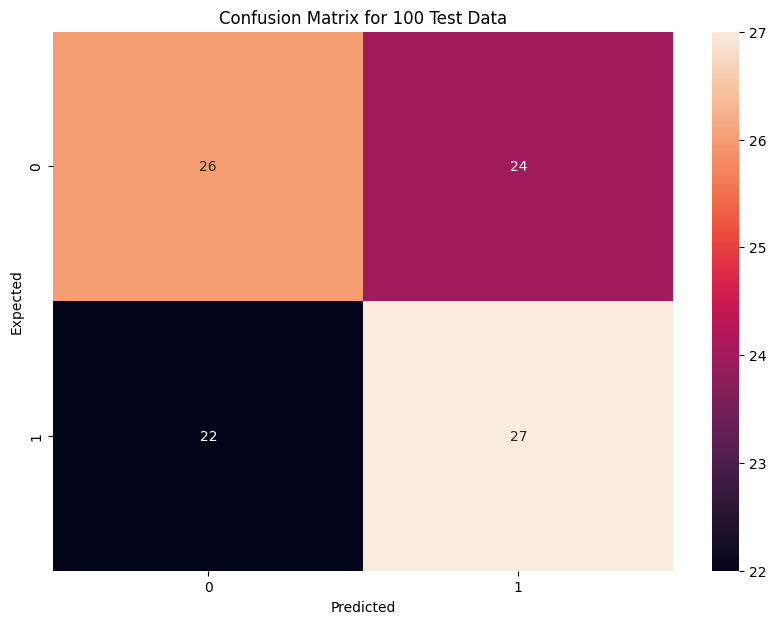

In [11]:
import seaborn
y_pred = model.predict(validation_generator, 20)
print('Confusion Matrix')
y_predicted_labels = y_pred > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  mid = 49
  start = mid-((total+1)//2)+1
  end = mid+((total+1)//2)
  cm = tf.math.confusion_matrix(labels=validation_generator.labels[start:end],predictions=y_predicted_labels[start:end])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

## Saving the model

In [12]:
# Save and convert the model (Used for deploying in web application)
model.save('model/image_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/image_model.h5 /content/image_model
print("Model converted to JSON successfully")

Saved the model successfully


c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'virtualenv' is not recognized as an internal or external command,
operable program or batch file.
'source' is not recognized as an internal or external command,
operable program or batch file.
ERROR: Exception:
Traceback (most recent call last):
  File "c:\users\lakshmi sri lasya\appdata\local\programs\python\python37\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\users\lakshmi sri lasya\appdata\local\programs\python\python37\lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
 

Model converted to JSON successfully



Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\converter.py", line 37, in <module>
    from tensorflowjs.converters import tf_saved_model_conversion_v2
  File "C:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflo

## Sample Example

In [13]:
"""
%pip install google-colab
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
"""
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
  print(fn + " - Sensitive")
  result[fn] = "Sensitive"
else:
  print(fn + " - Non-sensitive")
  result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))
"""   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)
"""

NameError: name 'x' is not defined